In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [2]:
db = CaseDB()

toload = [ 
    dict(name="legacy", id="d40db-mfp1", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="fixcond", id="d42acb-with_guards", unnormalise_geom = True, use_xhermes = True, squash = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case d40db-mfp1
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done

Unnormalising with xHermes
- Reading case d42acb-with_guards
-----------------------
- Looking for squash file
- Squash file found. squash date 09/03/2024, 10:49:23, dmp file date 09/03/2024, 10:28:10


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Read SOLEDGE

In [3]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

# Read SOLPS

In [4]:
solpscases = {
    # "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    # "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    # "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    # "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    # "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    # "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    # "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    
    "core_extent_16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
    "widewall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19",
    "tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
    "tightwall_noD2_1e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2",
    "tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
    "tightwall_noD2_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2",
    
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Read Hermes-3

In [8]:
cs.keys()

dict_keys(['new_a0.2', 'new_a0.6', 'new_a1.0', 'a1.0_frec0.68', 'fix_perpcond', 'braginskii'])

In [5]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    ds = cs[name].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    hr[name].read_case(ds)

    
    ds = cs[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

legacy


braginskii


# Convergence

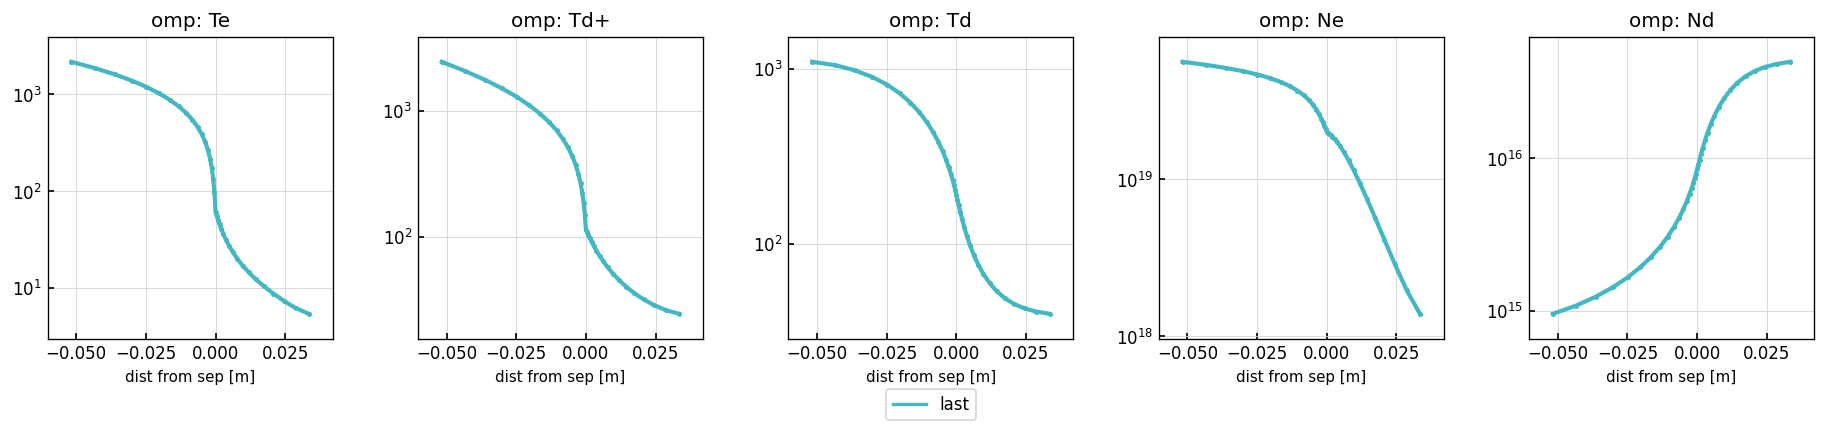

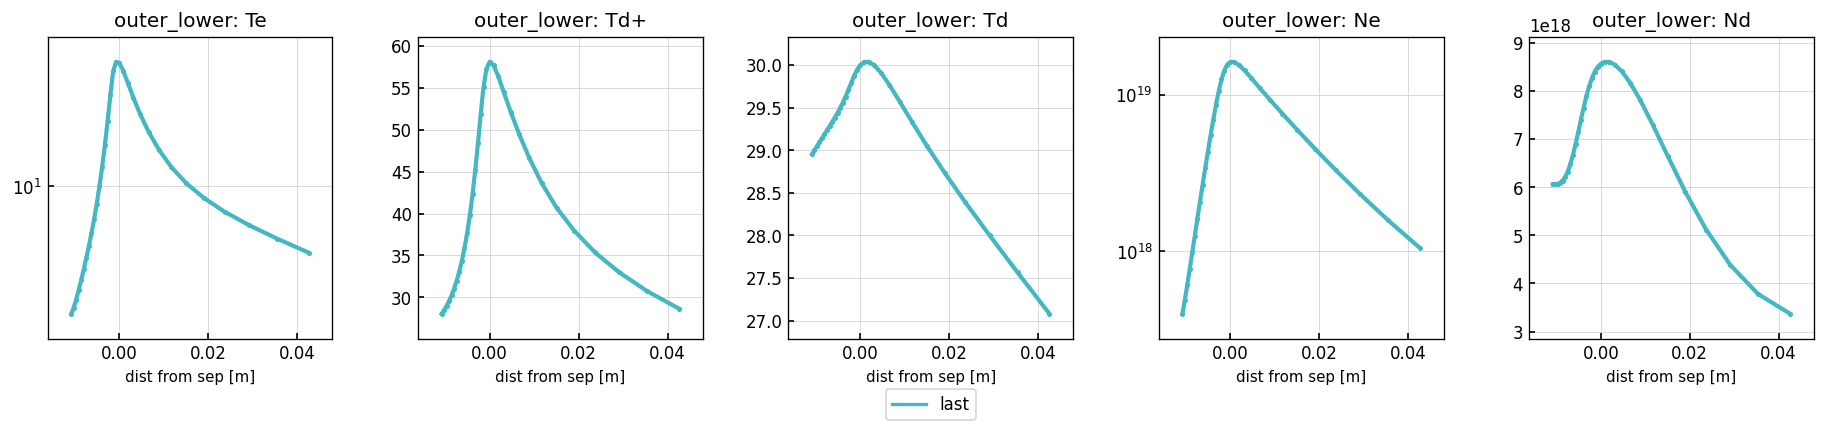

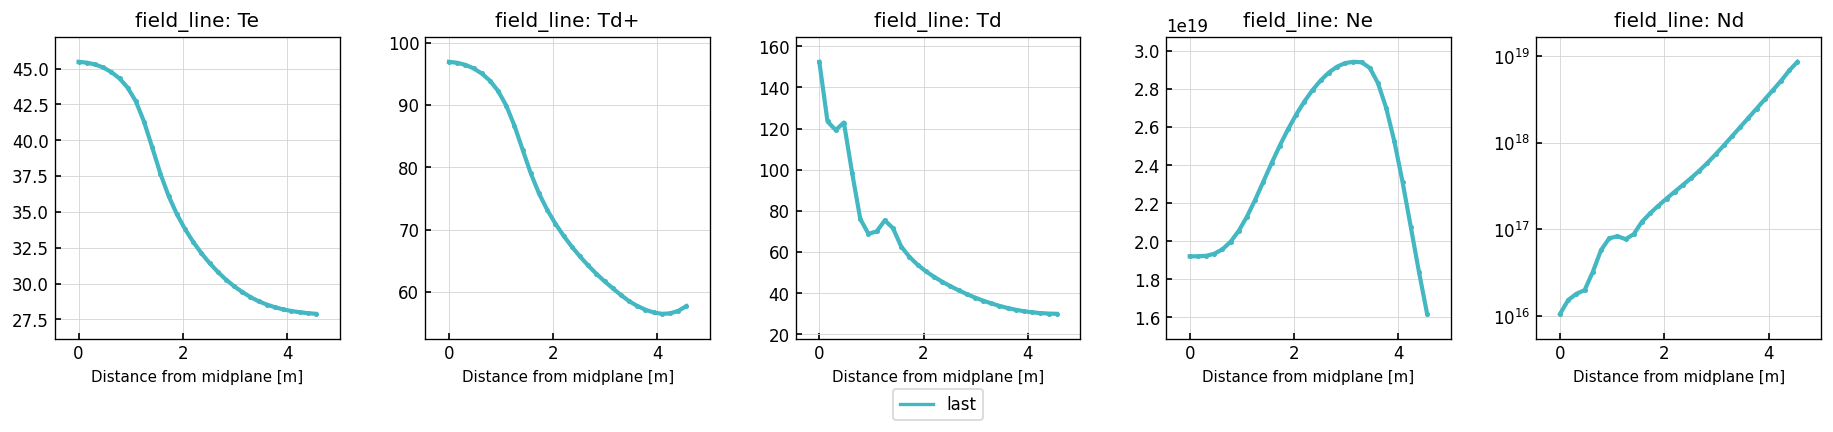

In [96]:
case = "no_fastrec_tune"
lineplot(
    {
        # "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        # "-5":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

# Comparison plots

In [6]:
cs.keys()

dict_keys(['legacy', 'braginskii'])

In [62]:
sp.keys()

dict_keys(['noiz_core', 'no_visc', '16x_mc', 'tightwall_2e19', 'tightwall_noD2_1e19', 'tightwall_noD2_2e19', 'tightwall_noD2_3e19'])

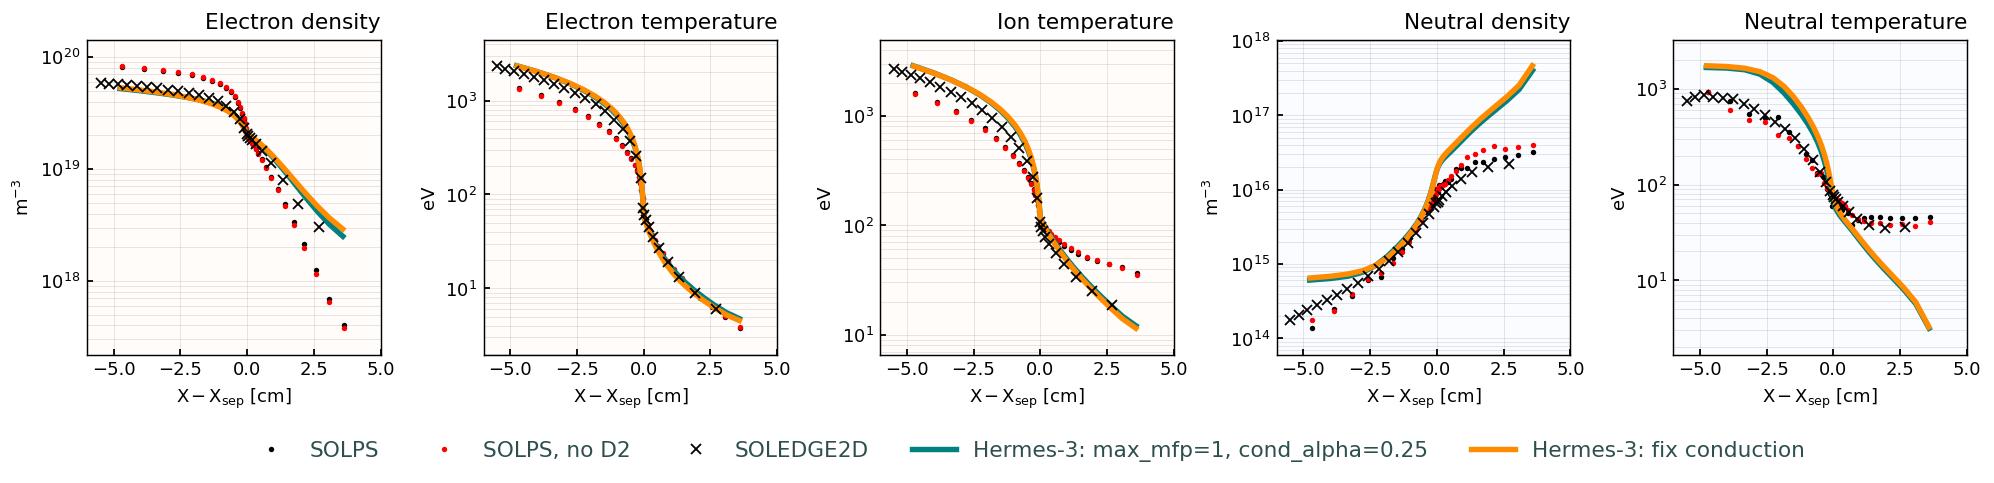

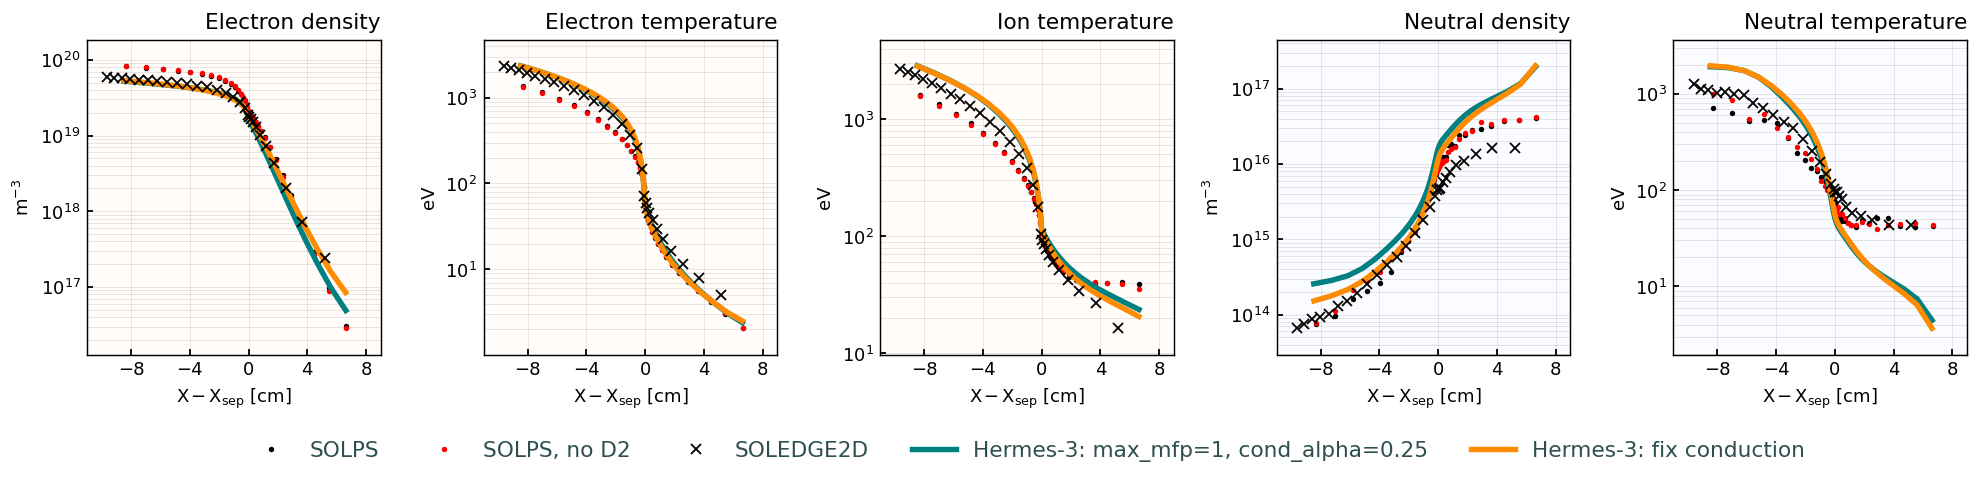

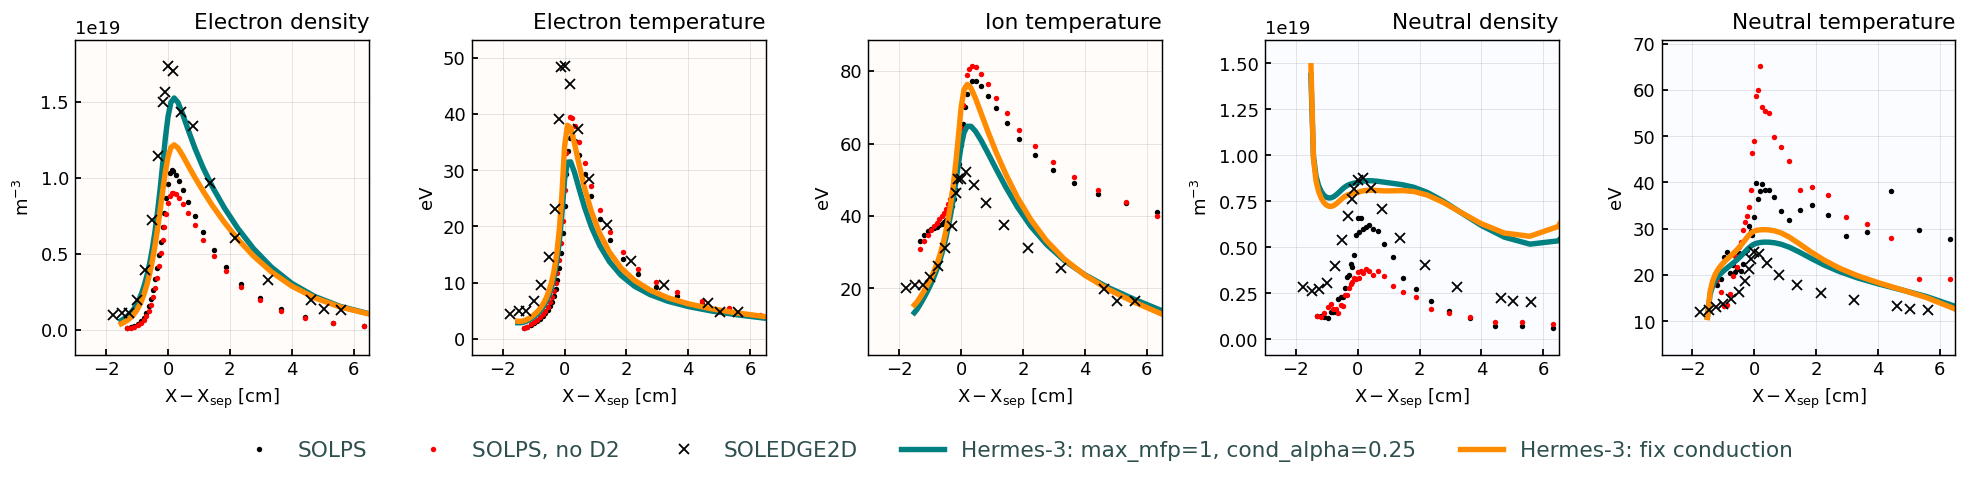

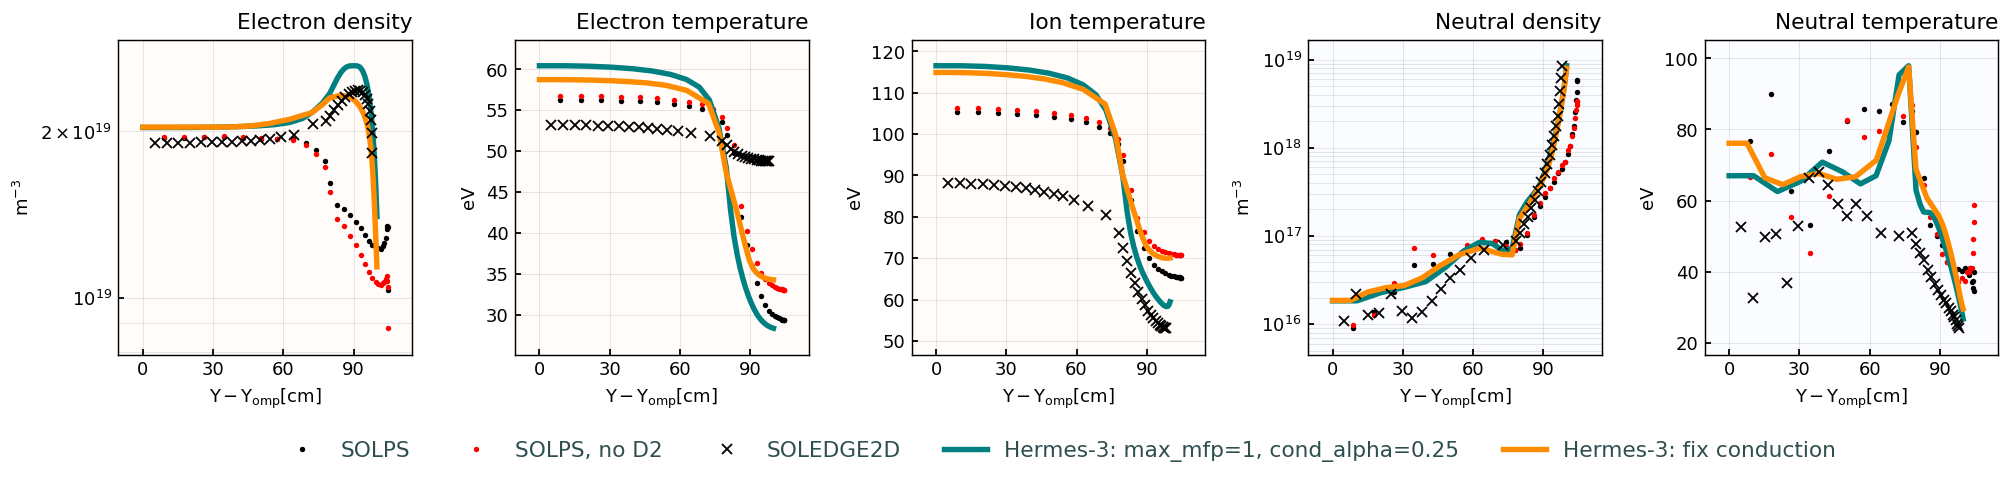

In [16]:
lineplot_compare(
    cases = { 
    "SOLPS" : dict(data=sp["tightwall_2e19"], color="black"),
    # "SOLPS: Full domain" : dict(data=sp["nsep_2e19"], color="black"),
    "SOLPS, no D2" : dict(data=sp["tightwall_noD2_2e19"], color="red"),
    "SOLEDGE2D" : dict(data=sl["tightwall_2e19"], color="black"),
    # "SOLEDGE2D: Full domain" : dict(data=sl["widewall_2e19"], color="black"),
    # r"Hermes-3: base" : dict(data=hr['base'], color = "teal"),
    # r"Hermes-3" : dict(data=hr['no_fastrec_tune'], color = "darkorange"),
    # r"Hermes-3: high max_mfp" : dict(data=hr['high_maxmfp'], color = "teal"),
    r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(data=hr['legacy'], color = "teal"),
    r"Hermes-3: fix conduction" : dict(data=hr['braginskii'], color = "darkorange"),
    # r"Hermes-3: limit conduction 0.25" : dict(data=hr['limit_cond_0.25'], color = "firebrick"),
    # r"Hermes-3: No fast recycling" : dict(data=hr['no_fastrec'], color = "firebrick"),
    # r"Hermes-3: No neutral reflection" : dict(data=hr['no_neutrefl'], color = "limegreen"),


    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"],  
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta"],
    mode = "log",
    dpi = 100,
    lw = 2,
    legend_nrows =1,
    combine_molecules = False
)

# Wall heat balance

## SOLEDGE

In [14]:
plt.close("all")

self = SOLEDGEcase(soledgecases["tightwall_2e19"])
slcWfluxes = self.get_wall_flux_summary()
display(slcWfluxes)

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed

 ********** 
 **********
get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed


,outer_wall,inner_wall,targets,pfr
E_Total,0.232057,0.038567,1.265799,0.102674
E_incident_Electron,0.000000,0.000000,0.553930,0.000234
E_incident_Ions,0.000000,0.000000,0.963330,0.001283
E_incident_Atoms,0.210326,0.026182,0.070519,0.081643
E_incident_Molecules,0.000000,0.000000,0.000000,0.000000
E_Radiation,0.021104,0.012336,0.019350,0.019273
E_Radiation_Atoms,0.021104,0.012336,0.019350,0.019273
E_Rad_Recombination,0.000000,0.000000,-0.451635,-0.000603
E_Recombination_in_Wall,0.000627,0.000048,0.110306,0.000843


## Hermes-3

In [15]:
hflows = []
for case in cs:

    df = calculate_neutral_heat_balance(cs[case].ds.isel(t=-1), mode = "reflection")
    df = df.loc[["total"], :]
    df.index = [case]
    
    hflows.append(df)
    
hflows = pd.concat(hflows, axis = 0)

In [43]:
hflows

,outer_wall,inner_wall,targets,pfr
base,0.340728,0.043582,0.114408,0.303970
no_fastrec_tune,0.403786,0.050262,0.137139,0.381936
no_fastrec,0.221385,0.026143,0.071519,0.165928
no_neutrefl,-0.000000,-0.000000,-0.000000,-0.000000
high_maxmfp,0.417425,0.043519,0.135362,0.380780
limit_cond,0.289797,0.036843,0.128166,0.298078


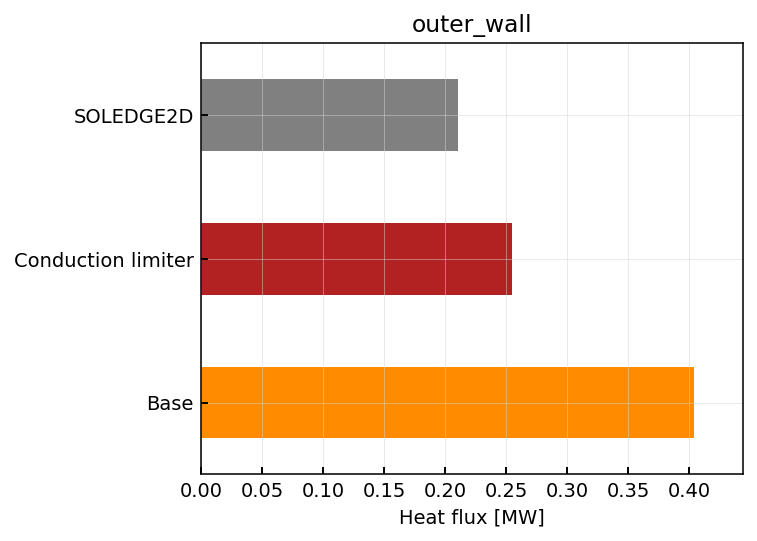

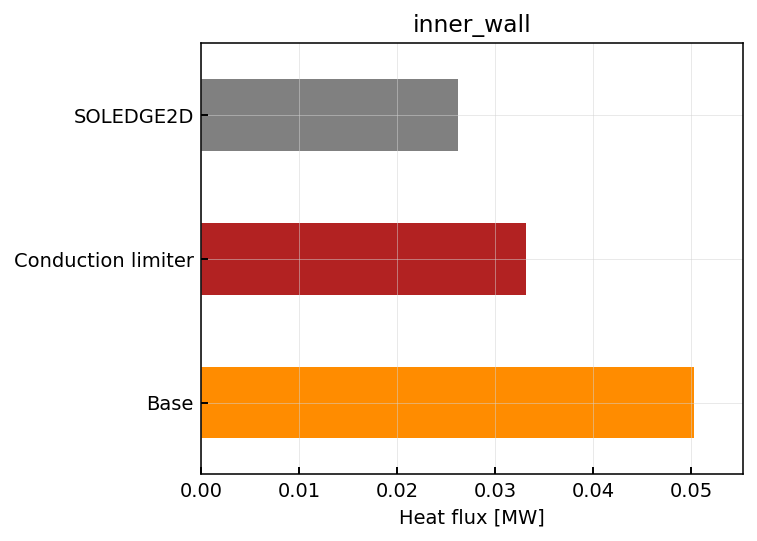

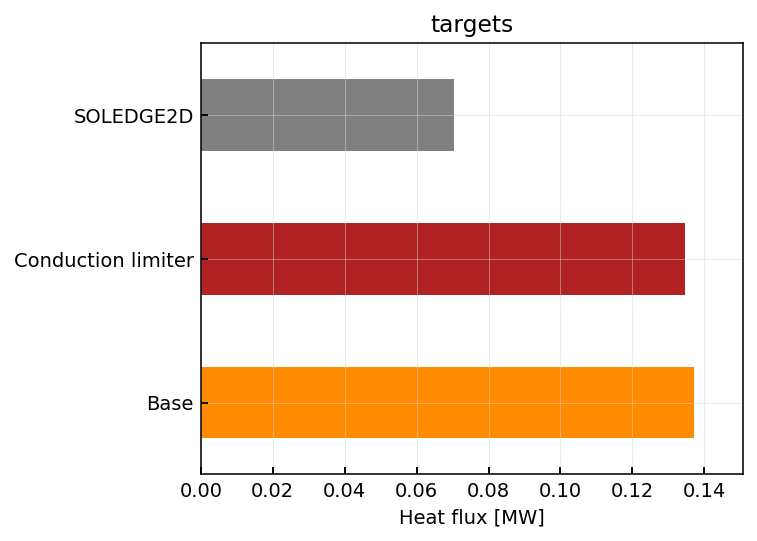

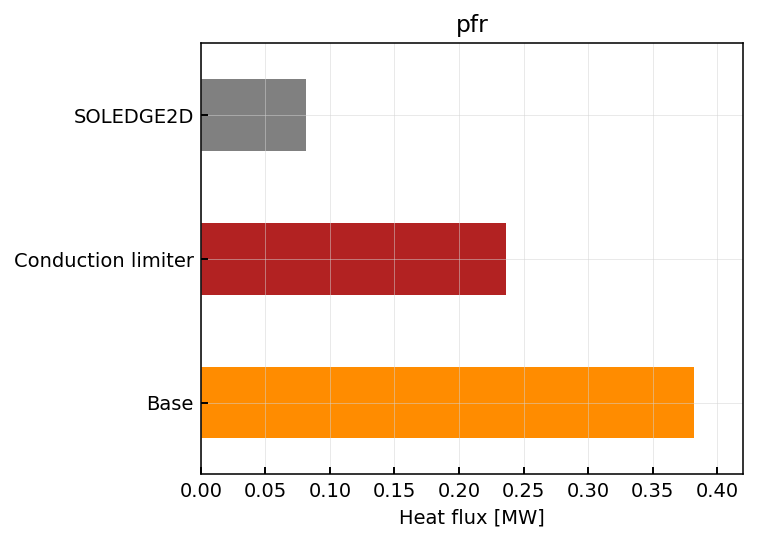

In [17]:
for loc in ["outer_wall", "inner_wall", "targets", "pfr"]:

    fig, ax = plt.subplots()
    dfplot = hflows
    dfplot = hflows.loc[["no_fastrec_tune", "limit_cond_0.25"]]
    dfplot.index = ["Base", "Conduction limiter"]

    # df1 = dfplot.loc[[x for x in dfplot.index if "base" in x], :]
    # df2 = dfplot.loc[[x for x in dfplot.index if "base" not in x], :]
    x = np.arange(len(dfplot)+1)
    width = 0.5
    # for i, case in enumerate(dfplot.index):
        # offset = width * i

    ax.barh(len(dfplot), slcWfluxes.loc["E_incident_Atoms", loc], width, color = "grey")
    # ax.barh(np.arange(len(dfplot)) , dfplot[loc], width, colors = ["darkorange", "firebrick"])
    ax.barh(0 , dfplot.loc["Base", loc], width, color = "darkorange")
    ax.barh(1 , dfplot.loc["Conduction limiter", loc], width, color = "firebrick")
    # ax.barh(np.arange(len(df2)), df2[loc], width)
        # ax.bar_label(rects, padding = 3)
        
    ax.set_yticks(x, list(dfplot.index) + ["SOLEDGE2D"])
    ax.set_xlabel("Heat flux [MW]")
    ax.set_title(loc)

In [83]:
cs.keys()

dict_keys(['base', 'no_fastrec_tune', 'no_fastrec', 'no_neutrefl', 'high_maxmfp', 'limit_cond'])

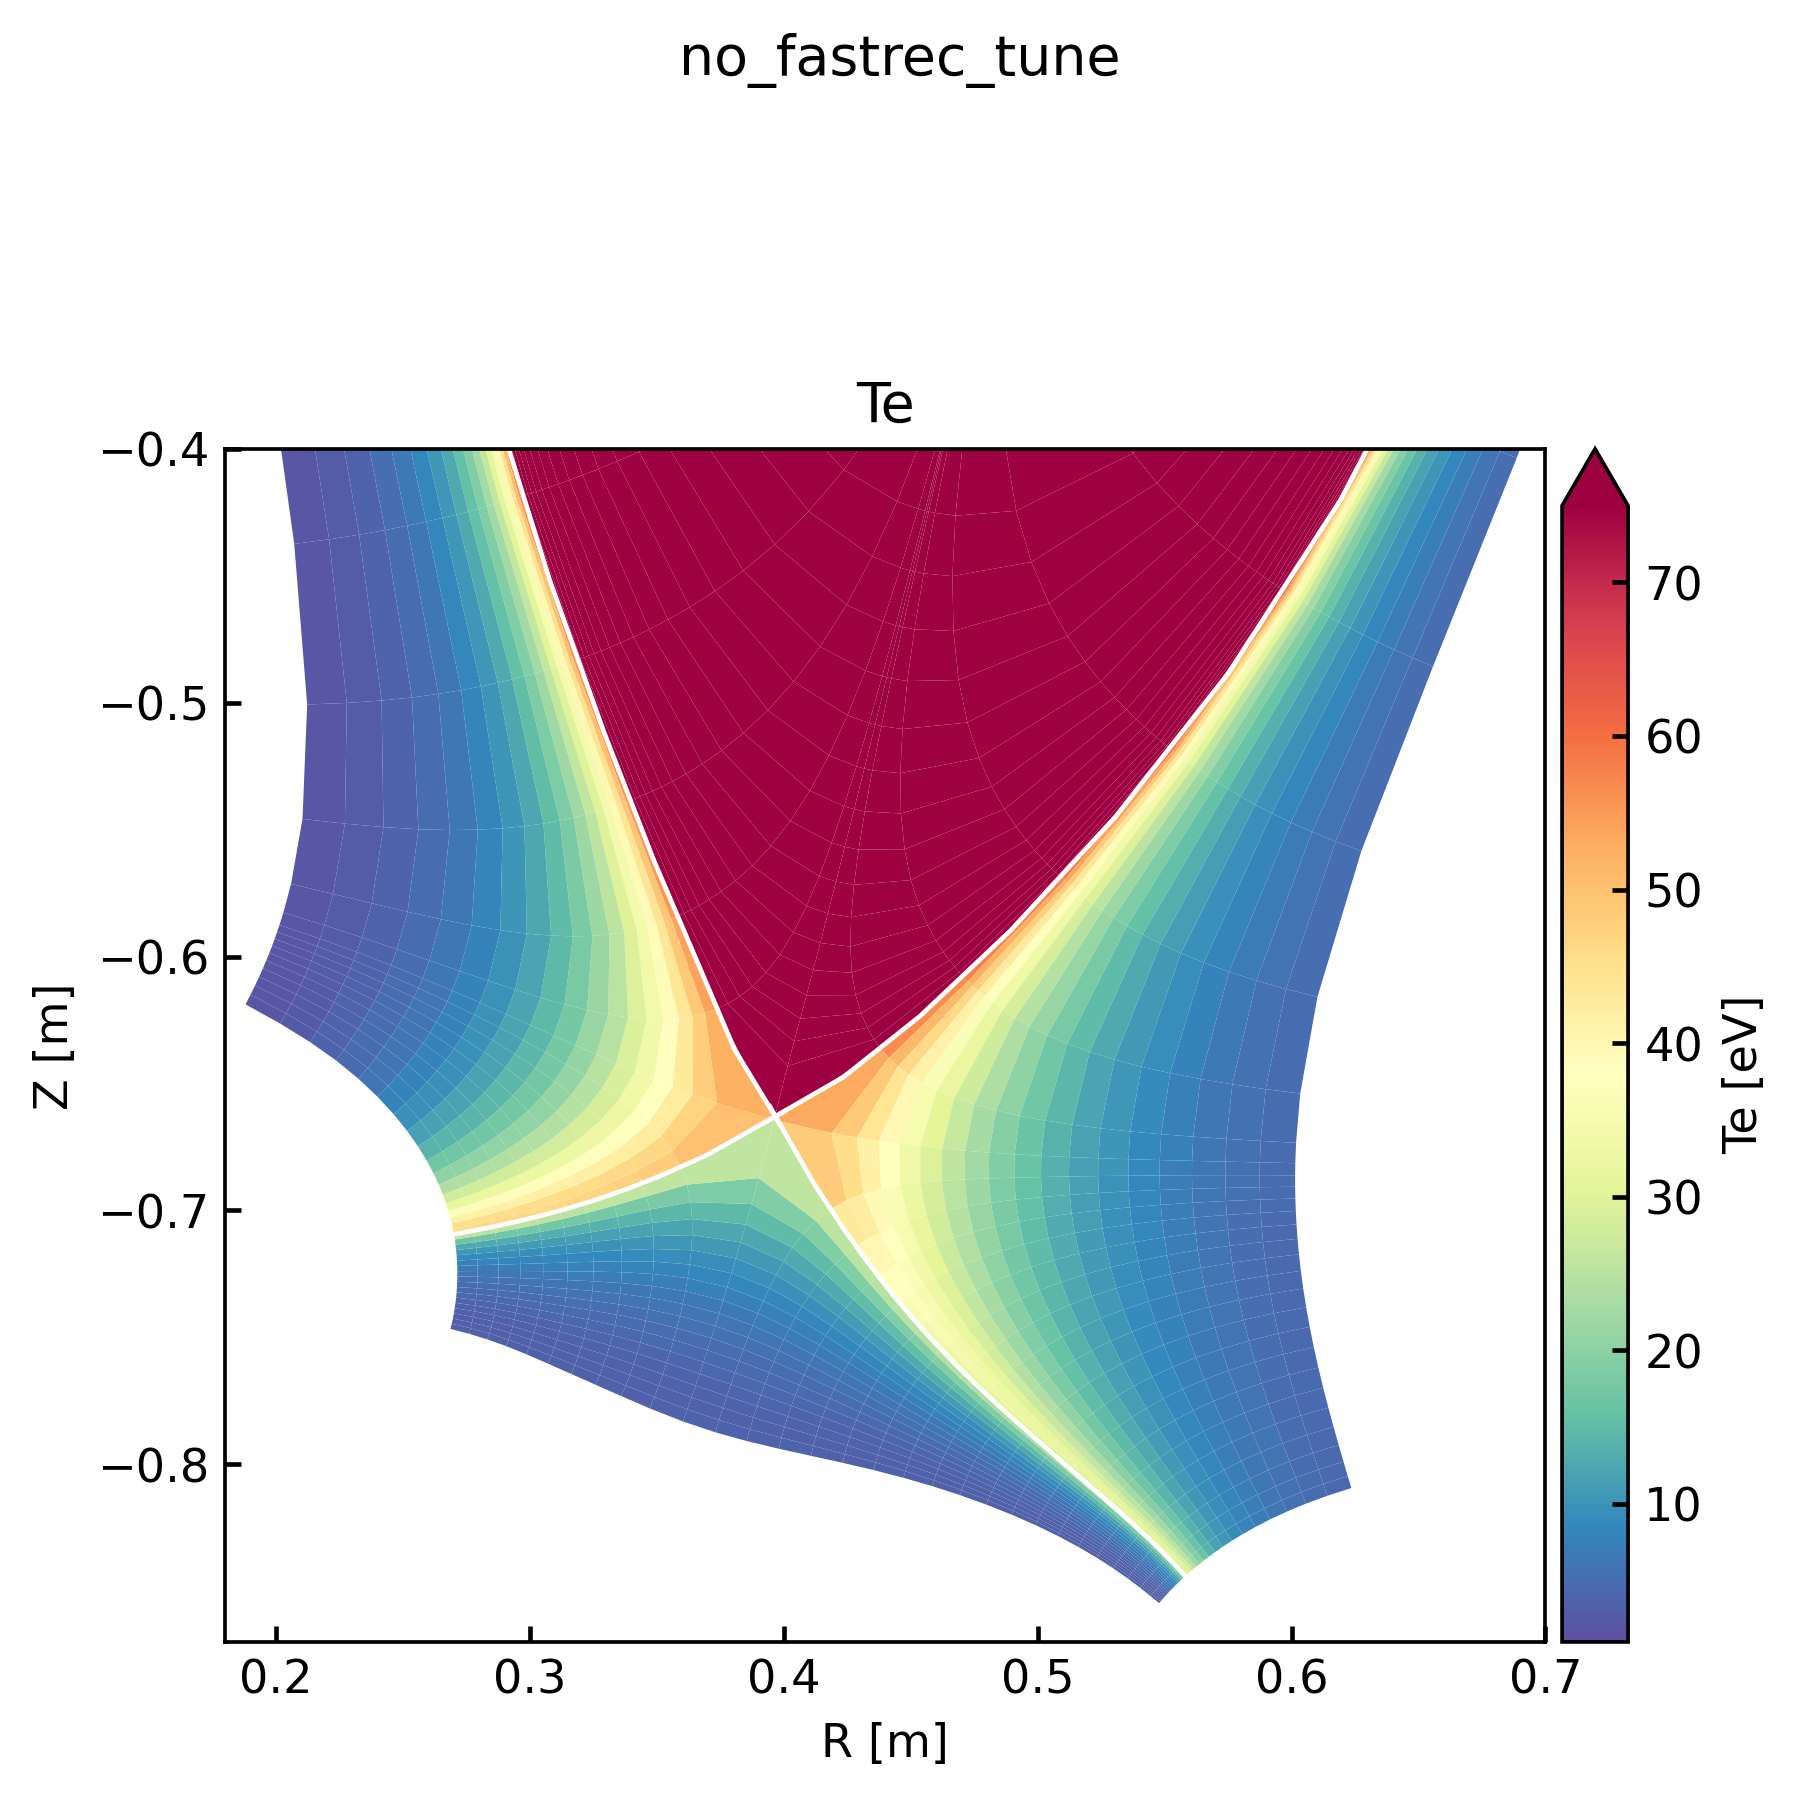

In [95]:


for case in ["no_fastrec_tune"]:
    ds = cs[case].ds.isel(t=-1)
    plot2d(
        [
            # dict(data = ds["Ne"], vmin = 1e18),
            dict(data = ds["Te"], vmin = 1, vmax = 75, logscale = False, extend = "max"),
            # dict(data = ds["Rc"]),
            # dict(data = ds["Rtot"]),
            # dict(data = ds["Nd"]),
            ], 
            xlim = (0.18, 0.7),
            ylim = (-0.87, -0.4),

            title = case,
            # margins = (100, 100),
            dpi = 500,
            scale = 1.5,
            grid = False)

# 3 Code 2D plot

In [11]:
cs.keys()

dict_keys(['legacy', 'braginskii'])

SOLEDGE: Combining Nmi and Nni


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


b2fgmtry loaded from .pkl
read_b2fgmtry -- file version 03.000.007
110 36


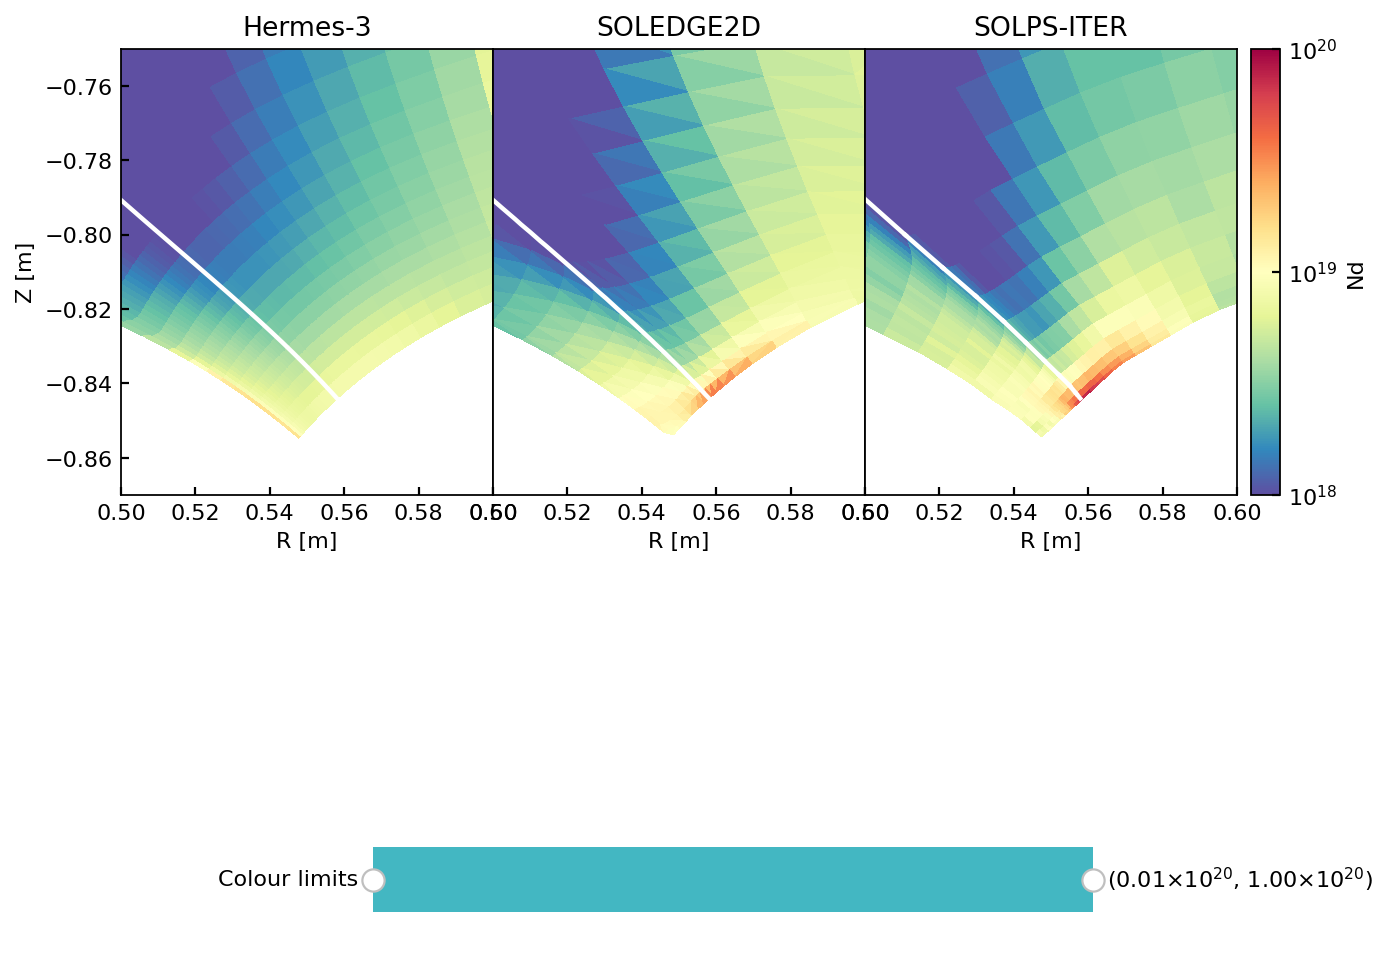

In [15]:
v = viewer_2d(
    "Nd",
    [
        {"name" : "Hermes-3", "code" : "hermes", "ds" : cs["braginskii"].ds.isel(t=-1)},
        {"name" : "SOLEDGE2D", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "SOLPS-ITER", "code":"solps", "path" : solpscases['tightwall_2e19']}
    ],
    logscale = True,
    # vmin = 10,
    # vmax = 1600,
    vmin = 1e18,
    vmax = 1e20,
    dpi = 160,
    ylim = (-0.87,-0.75),
    xlim = (0.5, 0.6),
    wspace = 0.0,
    cmap = "Spectral_r"
    # cmap = "rainbow"
)

# Radial neutral transport

In [15]:
for case in cs:
    cs[case].ds = calculate_radial_fluxes(cs[case].ds)

In [39]:
cs.keys()

dict_keys(['base', 'no_fastrec_tune', 'no_fastrec', 'no_neutrefl', 'high_maxmfp', 'limit_cond'])

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


Text(0.5, 1.0, 'Midplane radial neutral advection')

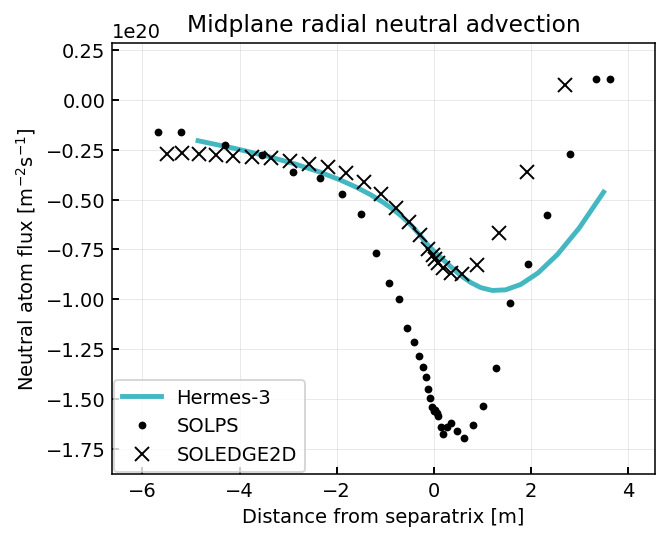

In [105]:
spc = SOLPScase(solpscases["tightwall_2e19"])
solps = spc.get_1d_radial_data(["rfluxa"], region = "omp")

fig, ax = plt.subplots()
kwargs = dict(lw = 2.5)


ds = cs["no_fastrec_tune"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
R = omp["dr"].cumsum()
dist = (R - R[ds.metadata["ixseps1"]])
# ax.plot(dist*100, omp["pf_perp_diff_R_d"] /  (omp["dy"]*omp["dz"]), **kwargs, label = f"Hermes-3: {case}")
ax.plot(dist*100, omp["ParticleFlow_d_xlow"] /  (omp["dy"]*omp["dz"]) , **kwargs, label = f"Hermes-3")

# SOLPS
ax.plot(solps.dist*100, solps["rfluxa"], label = "SOLPS", marker = "o", ms = 3, c = "k", lw = 0, alpha = 1)

# SOLEDGE
slc = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
df = slc.get_1d_radial_data(["vxni", "Nni", "Nmi"])
df["NVxn"] = df["vxni"] * df["Nni"]
ax.plot(df["dist"]*100, df["NVxn"], lw=0, marker = "x", ms = 7, markeredgewidth=1.0, label = "SOLEDGE2D", c = "black")

ax.legend()

ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral atom flux [$m^{-2}s^{-1}$]")
ax.set_title("Midplane radial neutral advection")

In [ ]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 150)
cases = ["frec_tune", "afnE_mfp1"]
labels = ["Hermes-3: Old model", "Hermes-3: Improved model"]
colors =None
# labels = ["flim=1", "flim=0.9", "flim=0.7"]

# colors = ["teal", "darkorange", "limegreen", "deeppink"]

for i, case in enumerate(cases):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    
    label = case if labels is None else labels[i]
    
    kwargs = {} if colors is None else dict(color = colors[i])
    ax.plot(dist*100, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = label, lw = 2.5, **kwargs)

# SOLEDGE
slc = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
df = slc.get_1d_radial_data(["vxni", "Nni", "Nmi"])
df["NVxn"] = df["vxni"] * df["Nni"]
ax.plot(df["dist"]*100, df["NVxn"], lw=0, marker = "x", ms = 7, markeredgewidth=1.0, label = "SOLEDGE2D", c = "black")

df["mfrac"] = df["Nmi"] / (df["Nni"] + df["Nmi"])

ax2 = ax.twinx()
ax2.plot(df["dist"]*100, df["mfrac"], lw = 1, c = "deeppink", ls = "--", label = "Molecule fraction")
ax2.set_ylabel("Molecule fraction: $N_{m}/(N_{a}+N_{m})$", color = "deeppink")
ax2.yaxis.label.set_color("deeppink")
ax2.tick_params(axis="y", colors = "deeppink")

ax.set_ylabel("Neutral radial particle flux $[m^{-2}s^{-1}]$")
ax.set_xlabel("$X - X_{sep}$ [cm]")
fig.legend(loc = "upper center",  bbox_to_anchor = (0.35,0.88), fontsize="small", frameon=True, framealpha = 1)
ax.set_xlim(-0.07*100, 0.05*100)
ax.set_ylim(-1.0e20, 0.25e20)

casestore.keys()
ax.grid(color = "k", alpha = 0.6)
ax.set_title("Particle transport at OMP")

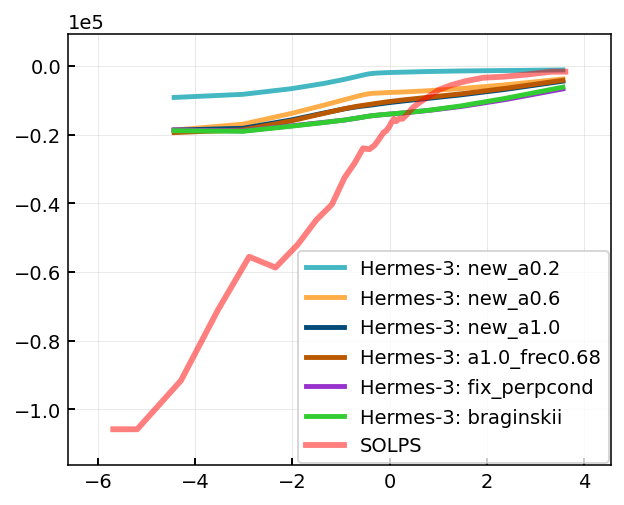

In [33]:
spc = SOLPScase(solpscases["tightwall_noD2_2e19"])
solps = spc.get_1d_radial_data(["rfluxa", "dab2"], region = "omp")

fig, ax = plt.subplots()
kwargs = dict(lw = 2.5)

for case in cs:
# for case in ["fix_eqns", "new_a0.2", "new_a0.6", "new_a1.0"]:
    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    R = omp["dr"].cumsum()
    dist = (R - R[ds.metadata["ixseps1"]])
    ax.plot(dist*100, omp["ParticleFlow_d_xlow"] /  (omp["dy"]*omp["dz"]) / omp["Nd"], **kwargs, label = f"Hermes-3: {case}")

ax.plot(solps.dist*100, solps["rfluxa"] /  solps["dab2"], label = "SOLPS", c = "r", lw = 3, alpha = 0.5)
ax.legend()


KeyError: 'ConductionFlow_d_xlow'

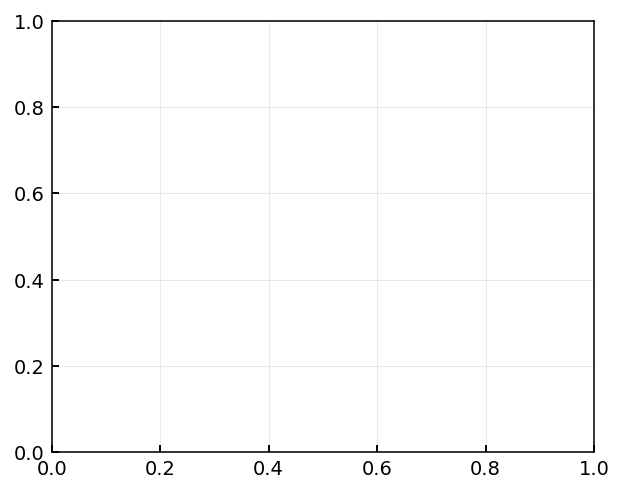

In [28]:
spc = SOLPScase(solpscases["tightwall_noD2_2e19"])
solps = spc.get_1d_radial_data(["rfluxa", "refluxa"], region = "omp")

fig, ax = plt.subplots()
kwargs = dict(lw = 2.5)

for case in cs:
# for case in ["fix_eqns", "new_a0.2", "new_a0.6", "new_a1.0"]:
    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    R = omp["dr"].cumsum()
    dist = (R - R[ds.metadata["ixseps1"]])
    ax.plot(dist*100, omp["EnergyFlow_d_xlow"] /  (omp["dy"]*omp["dz"]) + omp["ConductionFlow_d_xlow"] /  (omp["dy"]*omp["dz"]), **kwargs, label = f"Hermes-3: {case}")

ax.plot(solps.dist*100, solps["refluxa"], label = "SOLPS", c = "r", lw = 3, alpha = 0.5)
ax.legend()
ax.set_ylim(-0.3e5, 0)
# ax.set_yscale("symlog")


In [44]:
cs.keys()

dict_keys(['base', 'fix_eqns', 'base_AFN'])

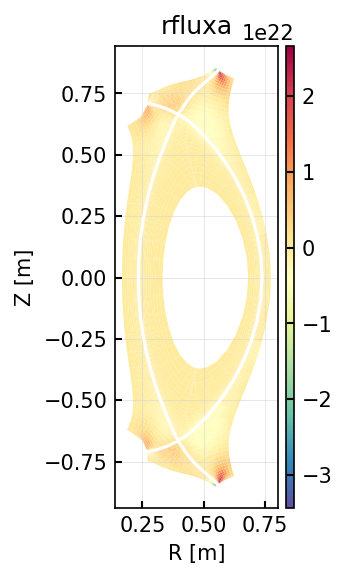

In [52]:
spc.plot_2d("rfluxa", cbar = True, logscale = False, antialias = True)

AttributeError: 'DataArray' object has no attribute 'set_xindex'

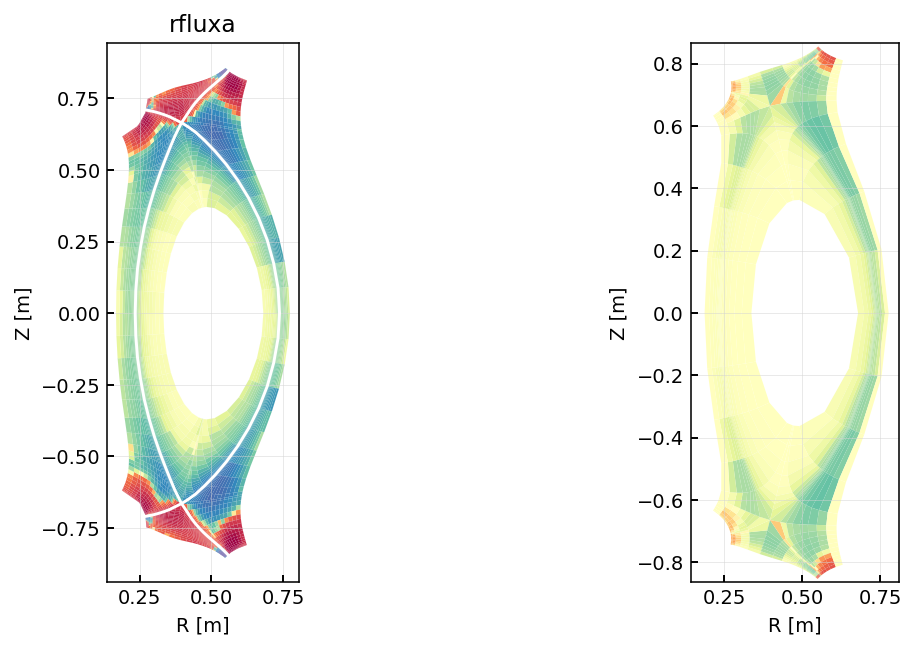

In [13]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
from hermes3.utils import create_norm
norm = create_norm(True, None, -1e22, 1e22, linthresh = 1e20)

## SOLPS
spc = SOLPScase(solpscases["tightwall_noD2_2e19"])
spc.plot_2d("rfluxa", norm = norm,  cbar = False, logscale = False, ax = axes[0], antialias = True)


## SOLEDGE
# slc = SOLEDGEcase(soledgecases["tightwall_2e19"])
# Ti = slc._get_2d_on_tri("Tempi")
# Te = slc._get_2d_on_tri("Tempe")
# ratio = Ti/Te


# slc.plot_2d(fig = fig, ax = axes[1], data = ratio, norm = norm, logscale = False, linewidth = 0)


## Hermes-3
ds = cs["new_a0.6"].ds.isel(t=-1)
(ds["pf_perp_diff_R_d"] /  (ds["dy"]*ds["dz"])).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", logscale = False, add_colorbar = False, norm = norm, antialias = True,
separatrix_kwargs = dict(color = "white", linestyle = "solid"), targets = False)


for ax in axes.flatten():
    # ax.set_ylim(-0.85, 0.05)
    
    # ax.set_xlim(0.2, 0.65)
    ax.set_ylim(-0.85, 0.1)
    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    
    
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = "Spectral_r"), cax = cax, label = "Ti/Te", extend = "both")
    
axes[0].set_title("SOLPS-ITER")
# axes[1].set_title("SOLEDGE2D")
axes[1].set_title("Hermes-3")
fig.subplots_adjust(wspace = 0.25)